In [26]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [27]:
def Batch2Col_test(batch: np.ndarray, kernel_shape: tuple[int, int]) -> np.ndarray:
    bs, h, w, c = batch.shape
    kh, kw = kernel_shape

    Hk = h - kh + 1
    Wk = w - kw + 1
    
    new_batch = []
    for b in range(bs):
        new_img = []
        for i in range(Hk):
            for j in range(Wk):
                patch = np.reshape(batch[b, i:i + kh, j:j + kw, :], (kh * kw * c, 1))
                new_img.append(patch)
        new_batch.append(np.concatenate(new_img, axis=-1))
    new_batch = np.array(new_batch)

    return new_batch

Kernels shape (Kh * Kw * C, N-kernels): (27, 3)
Batch shape (Batch-size, Kh * Kw * C, Nh * Nw): (2, 27, 9)
Batch of transposed images (Batch-size, Nh * Nw, Kh * Kw * C): (2, 9, 27)
New Image shape (Batch-size, Nh * Nw, C-out): (2, 9, 3)
Result batch (Batch-size, Nh, Nw, C-out) (2, 3, 3, 3)


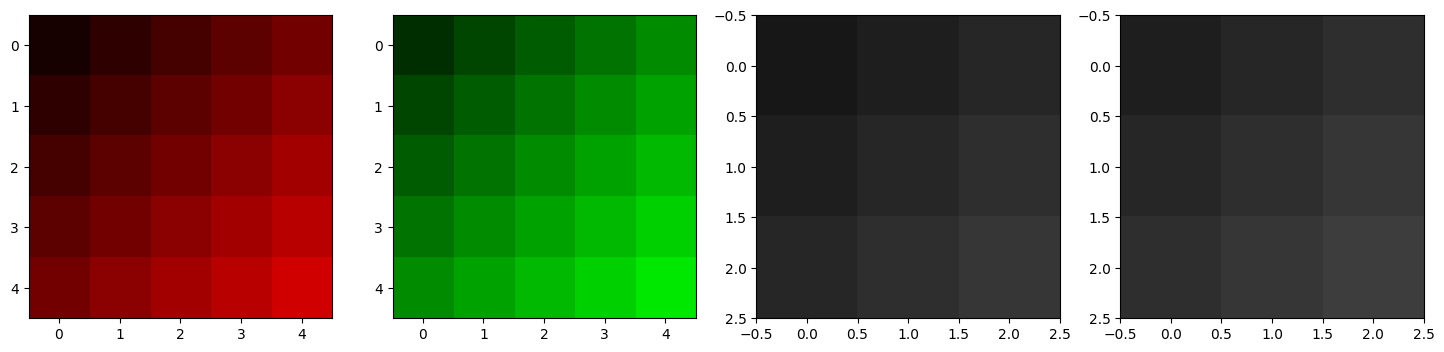

In [28]:
orig_img = np.zeros((5, 5, 3), dtype=np.float64)

Hin, Win, c = orig_img.shape
for k in range(c):
    for i in range(Hin):
        for j in range(Win):
            orig_img[i, j, k] = i + j + k + 1
orig_img = orig_img / orig_img.max()

kernel = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                   [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                   [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])
Kh, Kw, _ = kernel.shape
kernel = kernel / (Kh * Kw * c)

kernel_col = np.reshape(kernel, (Kh * Kw * c, 1))

kernels = np.concatenate([kernel_col, kernel_col, kernel_col], axis=-1)

red_img = orig_img.copy()
red_img[:, :, 0] *= 255
red_img[:, :, 1] = 0
red_img[:, :, 2] = 0

green_img = orig_img.copy()
green_img[:, :, 0] = 0
green_img[:, :, 1] *= 255
green_img[:, :, 2] = 0

kernels = np.concatenate([kernel_col, kernel_col, kernel_col], axis=-1)
print("Kernels shape (Kh * Kw * C, N-kernels):", kernels.shape)

img_batch = np.array([red_img, green_img])
img_cols = Batch2Col_test(img_batch, (3, 3))
# Nh - num of patches along column
# Nw - num of patches along row
print("Batch shape (Batch-size, Kh * Kw * C, Nh * Nw):", img_cols.shape)
img_cols = img_cols.transpose((0, 2, 1))
print("Batch of transposed images (Batch-size, Nh * Nw, Kh * Kw * C):", img_cols.shape)

new_img = np.matmul(img_cols, kernels)
print("New Image shape (Batch-size, Nh * Nw, C-out):", new_img.shape)

new_img = np.reshape(new_img, (2, 3, 3, 3))
print("Result batch (Batch-size, Nh, Nw, C-out)", new_img.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

ax[0].imshow(np.uint8(red_img))
ax[1].imshow(np.uint8(green_img))
ax[2].imshow(np.uint8(new_img[0]))
ax[3].imshow(np.uint8(new_img[1]))

### Математика процесса одного шага свёртки

Есть набор картинок (батч) размера (Bs, Hin, Win, Cin), где Bs - размер батча, Hin - высота изображения, Win - ширина изображения, Cin - количество входных каналов (3 в большинстве случаев)

Все картинки в батче нужно преобразовать в матрицы (массивы колонок), где каждый столбец - это развёрнутый в столбец патч (часть изображения размером с ядро), операция Img2Col. Пусть фунцкия для всего батча Batch2Col.

Batch2Col:
- Принимает массив формы входного батча (зависит от слоя)
- Выдаёт массив формы (Bs, Kh * Kw * Cin, Nh * Nw)
Здесь Kh - высота ядра, Kw - ширина ядра, C - количество каналов входного батча, Nh = Hin - Kh + 1 - количество патчей по вертикали, Nw = Win - Kw + 1 - количество патчей по горизонтали. При том что мы берём stride = 1, Nh и Nw эквивалентны Hout и Wout - размерам выходного изображения в батче.

Перевод патча в колонку можно выполнить простым развёртыванием через `reshape` в формат (Kh * Kw * Cin, 1) - вектор-столбец, что нам и нужно. Столбцы по изображению объединяем в матрицу, а матрицы обратно в батч.

Формула свёртки после Img2Col: $B^T = K^T \cdot ImgCols$, где B - выходное изображение в виде вектора-строки, K - ядро в виде вектора-столбца, ImgCols - матрица из Img2Col. Соответсвенно можно переписать в виде $B = {ImgCols}^T \cdot K$.
Обобщим на более чем одно ядро, тогда мы можем представить K как матрицу формы (Kh * Kw * Cin), где столбцы - развёрнутые ядра. Тогда B - выходная матрица формата (Nh * Nw, Cout), где Cout - количество ядер или же выходных каналов.

Теперь обощим на батч. Всё останется почти тем же, только добавится ещё измерение батчей.

Для полного пайплайна работы слоя добавим паддинг для сохранения размера.
Тогда получаем следующий алгоритм:
1) Input: (Bs, Hin, Win, Cin)
2) Padding: (Bs, Hpad = Hin + pad * 2, Wpad = Win + pad * 2, Cin)
3) Batch2Col: (Bs, Kh * Kw * Cin, Nh * Nw)
4) Transpose batch (0, 2, 1): (Bs, Nh * Nw, Kh * Kw * Cin)
5) Convolution (matmul): ImgCols(Bs, Nh * Nw, Kh * Kw * Cin) @ (Kh * Kw * Cin, Cout) = (Bs, Nh * Nw, Cout)
6) Reshape to normal form: (Bs, Nh, Nw, Cout)

In [29]:
def Batch2Col(batch: np.ndarray, kernel_shape: tuple[int, int]) -> np.ndarray:
    Bs, Hin, Win, Cin = batch.shape
    Kh, Kw = kernel_shape

    Nh = Hin - Kh + 1
    Nw = Win - Kw + 1
    
    new_batch = []
    for b in range(Bs):
        new_cols = []
        for i in range(Nh):
            for j in range(Nw):
                patch = np.reshape(batch[b, i:i + Kh, j:j + Kw, :], (Kh * Kw * Cin, 1))
                new_cols.append(patch)
        new_batch.append(np.concatenate(new_cols, axis=-1))
    new_batch = np.array(new_batch)

    return new_batch

In [30]:
def Conv(batch: np.ndarray, Cin: int, kernel_size: tuple[int, int] = (3, 3), Cout: int = 1, pad: int = 0) -> np.ndarray:
    # __init__
    Kh, Kw = kernel_size

    in_kernel = np.zeros((Kh * Kw * Cin, Cout), dtype=np.float64)
    in_kernel[:, :] = 1 / in_kernel.shape[0]

    # __runtime__
    Bs, Hin, Win, _ = batch.shape
    padded_batch = np.zeros((Bs, Hin + pad * 2, Win + pad * 2, Cin), dtype=np.float64)
    padded_batch[:, pad:Hin + pad, pad:Win + pad, :] = batch
    Bs, Hin, Win, _ = padded_batch.shape
    Nh = Hin - Kh + 1
    Nw = Win - Kw + 1
    

    BatchCols = Batch2Col(padded_batch, kernel_size)
    BatchColsT = BatchCols.transpose((0, 2, 1))
    
    conv = np.matmul(BatchColsT, in_kernel)
    conv_r = conv.reshape((Bs, Nh, Nw, Cout))
    
    return conv_r

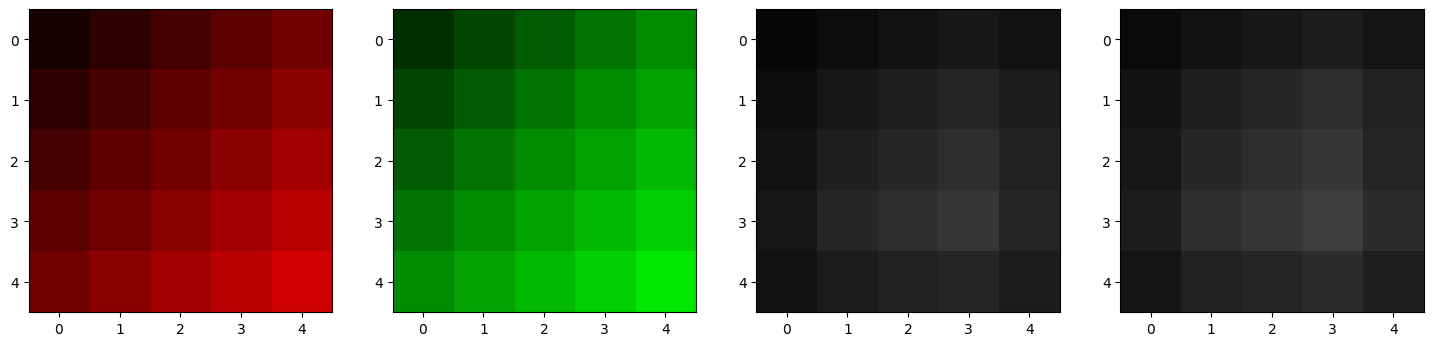

In [31]:
orig_img = np.zeros((5, 5, 3), dtype=np.float64)

Hin, Win, c = orig_img.shape
for k in range(c):
    for i in range(Hin):
        for j in range(Win):
            orig_img[i, j, k] = i + j + k + 1
orig_img = orig_img / orig_img.max()

red_img = orig_img.copy()
red_img[:, :, 0] *= 255
red_img[:, :, 1] = 0
red_img[:, :, 2] = 0

green_img = orig_img.copy()
green_img[:, :, 0] = 0
green_img[:, :, 1] *= 255
green_img[:, :, 2] = 0

img_batch = np.array([red_img, green_img])

new_img = Conv(img_batch, 3, (3, 3), 3, 1)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

ax[0].imshow(np.uint8(red_img))
ax[1].imshow(np.uint8(green_img))
ax[2].imshow(np.uint8(new_img[0]))
ax[3].imshow(np.uint8(new_img[1]))